#### Read syn++ yaml file and fit synthetic spectra

In [190]:
# Import required packages and modules
#-------------------------------------------------------------------------------#
import os
import glob
import yaml
import subprocess
import numpy as np
import pandas as pd
import Useful_python_functions
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

#-------------------------------------------------------------------------------#

In [191]:
#spectra_dir = '/home/anirban/2020sck/Results/New_Results/Spectra/Synthetic_spectra/2020-08-31/'

target_spec = os.path.join(spectra_dir, 'z_dgrts2020-09-07_SN2020sck.dat')
synow_yaml = os.path.join(spectra_dir, '2017-10-25_all.yaml')
synow_out = os.path.join(spectra_dir, 'synow_out.dat')

c_ii = os.path.join(spectra_dir, 'CII.dat')
c_iii = os.path.join(spectra_dir, 'CIII.dat')
o_i = os.path.join(spectra_dir, 'OI.dat')
o_id = os.path.join(spectra_dir, 'OID.dat')
na_i = os.path.join(spectra_dir, 'NaI.dat')
mg_ii = os.path.join(spectra_dir, 'MgII.dat')
si_ii = os.path.join(spectra_dir, 'SiII_PV.dat')
si_ii_hv = os.path.join(spectra_dir, 'SiII_HV.dat')
si_iii = os.path.join(spectra_dir, 'SiIII.dat')
s_ii = os.path.join(spectra_dir, 'SII.dat')
Ca_ii = os.path.join(spectra_dir, 'CaII.dat')
sc_ii = os.path.join(spectra_dir, 'ScII.dat')
Ti_ii = os.path.join(spectra_dir, 'TiII.dat')
Fe_ii = os.path.join(spectra_dir, 'FeII.dat')
Fe_iii = os.path.join(spectra_dir, 'FeIII.dat')
Co_ii = os.path.join(spectra_dir, 'CoII.dat')
Co_iii = os.path.join(spectra_dir, 'CoIII.dat')

os.chdir(spectra_dir)

In [192]:
synow_config=Useful_python_functions.open_yaml(synow_yaml)

In [193]:
def remove_file(file_name):
    """
    Removes the file 'file_name' in the constituent directory.
    Args:
         file_name  : Name of the file to be removed from the current directory
    Returns:
        None
    """
    try:
        os.remove(file_name)
    except OSError:
        pass


def remove_similar_files(common_text):
    """
    Removes similar files based on the string 'common_text'.
    Args:
        common_text : String containing partial name of the files to be deleted
    Returns:
        None
    """
    for residual_file in glob.glob(common_text):
        remove_file(residual_file)


def group_similar_files(text_list, common_text, exceptions=''):
    """
    Groups similar files based on the string 'common_text'. Writes the similar files
    onto the list 'text_list' (only if this string is not empty) and appends the similar
    files to a list 'python_list'.
    Args:
        text_list   : Name of the output text file with names grouped based on the 'common_text'
        common_text : String containing partial name of the files to be grouped
        exceptions  : String containing the partial name of the files that need to be excluded
    Returns:
        list_files  : Python list containing the names of the grouped files
    """
    list_files = glob.glob(common_text)
    if exceptions != '':
        list_exception = exceptions.split(',')
        for file_name in glob.glob(common_text):
            for text in list_exception:
                test = re.search(text, file_name)
                if test:
                    try:
                        list_files.remove(file_name)
                    except ValueError:
                        pass

    list_files.sort()
    if len(text_list) != 0:
        with open(text_list, 'w') as f:
            for file_name in list_files:
                f.write(file_name + '\n')

    return list_files

def smooth_1dspec(common_text, sp = 20, kernel = 'gaussian', prefix_str = 'z_', plot = False):
    
    """
    Smoothens a 1-D spectra based on the smoothening parameter. Smoothening parameter
    is 'std.dev.' in case of isotropic Gaussian filter and is 'width' in the case of the
    non-isotropic box filter.
    Args:
        common_text : Common text of 1-D spectra files which have to be smoothened
        sp          : Smoothening parameter
        kernel      : Convolution Kernel used for smoothening (Gaussian or Box)
        prefix_str  : Prefix to distinguish the smoothened 1-D spectra from the original
        plot        : Boolean describing whether the smoothened spectra has to be plotted
    Returns:
        None
    """
    for text in ['z_*.dat']:
        remove_similar_files(text)
    from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
    list_spectra = group_similar_files('', common_text = common_text)
    print (list_spectra)
    usable_kernel = Gaussian1DKernel(int(sp), mode='oversample')
    
    if kernel.lower() != 'gaussian':
        if kernel.lower == 'box':
            usable_kernel = Box1DKernel(int(sp))
        else:
            print ("Error: Kernel '{0}' Not Recognised".format(kernel))
            sys.exit(1)
            
    for file_name in list_spectra:
        #wave_data, flux_data = read_1dspec(file_name)
        #smoothed_data = convolve(flux_data, usable_kernel)
        #write_1dspec(ref_filename = file_name, flux_array = smoothed_data, prefix_str = prefix_str)
        columns = ['Wave', 'Flux']
        unsmoothed_df = pd.read_csv(file_name, sep='\s+', names=columns, engine='python')
        #print (type(unsmoothed_df['Flux'].values))
        smoothed_flux = convolve(unsmoothed_df['Flux'].values, usable_kernel)
        wave_array = unsmoothed_df['Wave'].values
        unsmoothed_flux = unsmoothed_df['Flux'].values
        smoothed_df = pd.DataFrame(list(zip(wave_array, smoothed_flux)), columns=['Wavelength', 'Flux'])
        smoothed_flux = smoothed_df['Flux'].values
        smoothed_df.to_csv(prefix_str+file_name, sep=' ', index=None, header=['Wavelength', 'Flux'])
        
        if plot:
            plt.figure(figsize=(6,6))
            plt.plot(wave_array, unsmoothed_flux, 'g', label = 'Original Spectrum')
            plt.plot(wave_array, smoothed_flux, 'r--', label = 'Smooth Spectrum', alpha=0.5)
            plt.legend()
            plt.show()
            plt.close()


def plot_spectra(target_file, synow_file, wave_clip=True, plot=False, log_scale=False, savefig=False):
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    #Useful_python_functions.plot_params(band='A', ax=ax, mil_x=)
    
    col_names = ['Wave', 'Flux']
    target_df = pd.read_csv(target_file, sep='\s+', names=col_names, engine='python')
    if wave_clip:
        target_df = target_df[(target_df['Wave'] >= int(3520)) & (target_df['Wave'] <= int(9500))]
    col_names = ['Wave', 'Flux', 'Flux_Err']
    synow_df = pd.read_csv(synow_file, sep='\s+', names=col_names, engine='python')
    #print (target_df)
    
    if plot:
        
        ax.plot(target_df['Wave'], target_df['Flux'], 'r-')
        ax.plot(synow_df['Wave'], synow_df['Flux'], 'b--')
        
    if log_scale:
        ax.plot(target_df['Wave'], np.log10(target_df['Flux']), 'r-')
        ax.plot(synow_df['Wave'], np.log10(synow_df['Flux']), 'b-')
        
        y = -15.0
        dict_label = {r'$\rm ----Si\,II$':[6200, y], r'$\rm ----S\,II$':[5300, y], 
                     r'$\rm ----O\,I$':[7500, y], r'$\rm ---Fe\,III$':[4900, y], 
                      r'$\rm ---C\,III$':[4500, y], r'$\rm -----Si\,III$':[4400, y],
                      r'$\rm ---Fe\,III$':[4200, y], r'$\rm ----Si\,II$':[3940, -14.8],
                      r'$\rm ----Ca\,II, Si\,II$': [3650, y]}

        #for (line, [wavelength, width]) in dict_label.items():
        #    ax.text(wavelength, width, line, fontsize = 22, rotation = 'vertical')   
            
            
        dict_label_1 = {r'$\rm ----Si\,II$':[6200, y], r'$\rm ---Fe\,III$':[4900, y]}
            
            
        #for (line, [wavelength, width]) in dict_label_1.items():
        #    ax.text(wavelength, width, line, fontsize = 22, rotation = 'vertical')  
        #    ax.axvspan(wavelength+100, wavelength + 40, facecolor='gray', alpha=0.5)
            #rint (wavelength
            
            
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_major_locator(MultipleLocator(1000))
        ax.xaxis.set_minor_locator(MultipleLocator(200))
        #ax.yaxis.set_major_locator(MultipleLocator(2e-15))
        #ax.yaxis.set_minor_locator(MultipleLocator(0.5e-15))

        ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 2.0, labelsize = 12)
        ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5, width = 1.2, labelsize = 12)

        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize = 25)
    
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize = 25)
    
        ax.set_ylim(-16.2, -13.5)    
        
    ax.text(4500, -15.8, r'$\rm -5.5\ day$', fontsize=20)
    
    if savefig:
        plt.savefig("/home/anirban.dutta/2020sck/Results/Plots/Synow_fit-1.png", 
                    dpi = 500, bbox_inches='tight', facecolor='white')
    
    
def plot_ion(target_file, synow_file, ion, offset=0.1, plot=False):
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    
    col_names = ['Wave', 'Flux']
    target_df = pd.read_csv(target_file, sep='\s+', names=col_names, engine='python')
    col_names = ['Wave', 'Flux', 'Flux_Err']
    synow_df = pd.read_csv(synow_file, sep='\s+', names=col_names, engine='python')
    
    
    if plot:
        
        ax.plot(target_df['Wave'], target_df['Flux'], 'r-')
        ax.plot(synow_df['Wave'], synow_df['Flux'] + offset, 'b--')
        ax.text(9500, synow_df['Flux'].values[-1] + offset, ion, fontsize=15)
        

In [194]:
synow_config['output']['min_wl'] = 3500.0
synow_config['output']['max_wl'] = 9000.0
synow_config['output']['wl_step'] = 2.0
synow_config['grid']['bin_width']= 0.3
synow_config['grid']['v_size'] = 100
synow_config['grid']['v_outer_max'] = 50.0
synow_config['opacity']['line_dir'] = '/usr/local/share/es/lines'
synow_config['opacity']['ref_file'] = '/usr/local/share/es/refs.dat'
synow_config['opacity']['form'] = 'exp'
synow_config['opacity']['v_ref'] = 10.0
synow_config['log_tau_min'] = -2.5
synow_config['source']['mu_size'] = 10
synow_config['spectrum']['p_size'] = 60
synow_config['spectrum']['flatten'] = 'No'
synow_config['setups'][0]['a0'] = 0.65e-15
synow_config['setups'][0]['a1'] = 0.0e-15
synow_config['setups'][0]['a2'] = 1.0e-15
synow_config['setups'][0]['v_phot'] = 5.0
synow_config['setups'][0]['v_outer'] = 30.0
synow_config['setups'][0]['t_phot'] = 10.5   # 12.2
synow_config['setups'][0]['ions'] = [1201, 1401, 1401, 1601, 1402, 2601, 2602, 2001, 2702, 602, 800, 2201, 
                                     601, 2101, 2701, 800, 801, 1100]
# Mg (1) , SiII_PV (2) , SiII_HV (3) , S_II (4) , SiIII (5) , FeII (6) , FeIII (7) , CaII (8) , 
# CoIII (9) , CIII (10) , OI (11) , TiII (12), CII (13) , ScII (14), CoII (15), OIDF (16) , 
# OII (17), NaI
synow_config['setups'][0]['active'] = [False, True, False, True, True, True, True, True, 
                                       False, True, True, False, True, True, True, True, False,
                                       True]
synow_config['setups'][0]['log_tau'] = [-0.8, -1.3, -0.8, -1.2, -1.1, -0.9, -0.9, -0.1, -0.1, -1.4, 
                                        -1.0, -1.8, -2.2, -1.8, -0.9, -1.2, 1.0, -1.8]
synow_config['setups'][0]['v_min'] = [5.4, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,
                                     5.0, 5.0, 5.0, 5.0, 11.0, 8.4, 5.0]
synow_config['setups'][0]['v_max'] = [15.0, 10.0, 15.0, 7.0, 7.0, 7.0, 8.0, 8.0, 6.0, 8.0, 15.0,
                                     12.0, 7.0, 7.0, 7.0, 15.0, 7.0, 10.0]
synow_config['setups'][0]['aux'] = [4.0, 2.7, 4.0, 5.0, 5.0, 5.0, 5.5, 4.0, 5.2, 3.0, 4.5, 
                                    6.0, 9.0, 2.5, 5.0, 3.0, 5.0, 5.0]
synow_config['setups'][0]['temp'] = [10, 7, 10, 5, 13, 10, 10, 5, 15, 15, 5, 10, 15, 
                                     15, 10, 5, 25, 10]


In [195]:
# Change the config file in the code only and dump 
#-------------------------------------------------------------------------------#
with open(synow_yaml, 'w') as f:
    yaml.dump(synow_config, f)
#-------------------------------------------------------------------------------#    

In [196]:
file_save = synow_out

if os.path.exists(file_save):
    Useful_python_functions.remove_file(file_save)

with open(file_save, 'w') as output_file:
    subprocess.run(args=["syn++", synow_yaml, '--wl-from=', target_spec], stdout=output_file)

output_file.close()

In [197]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

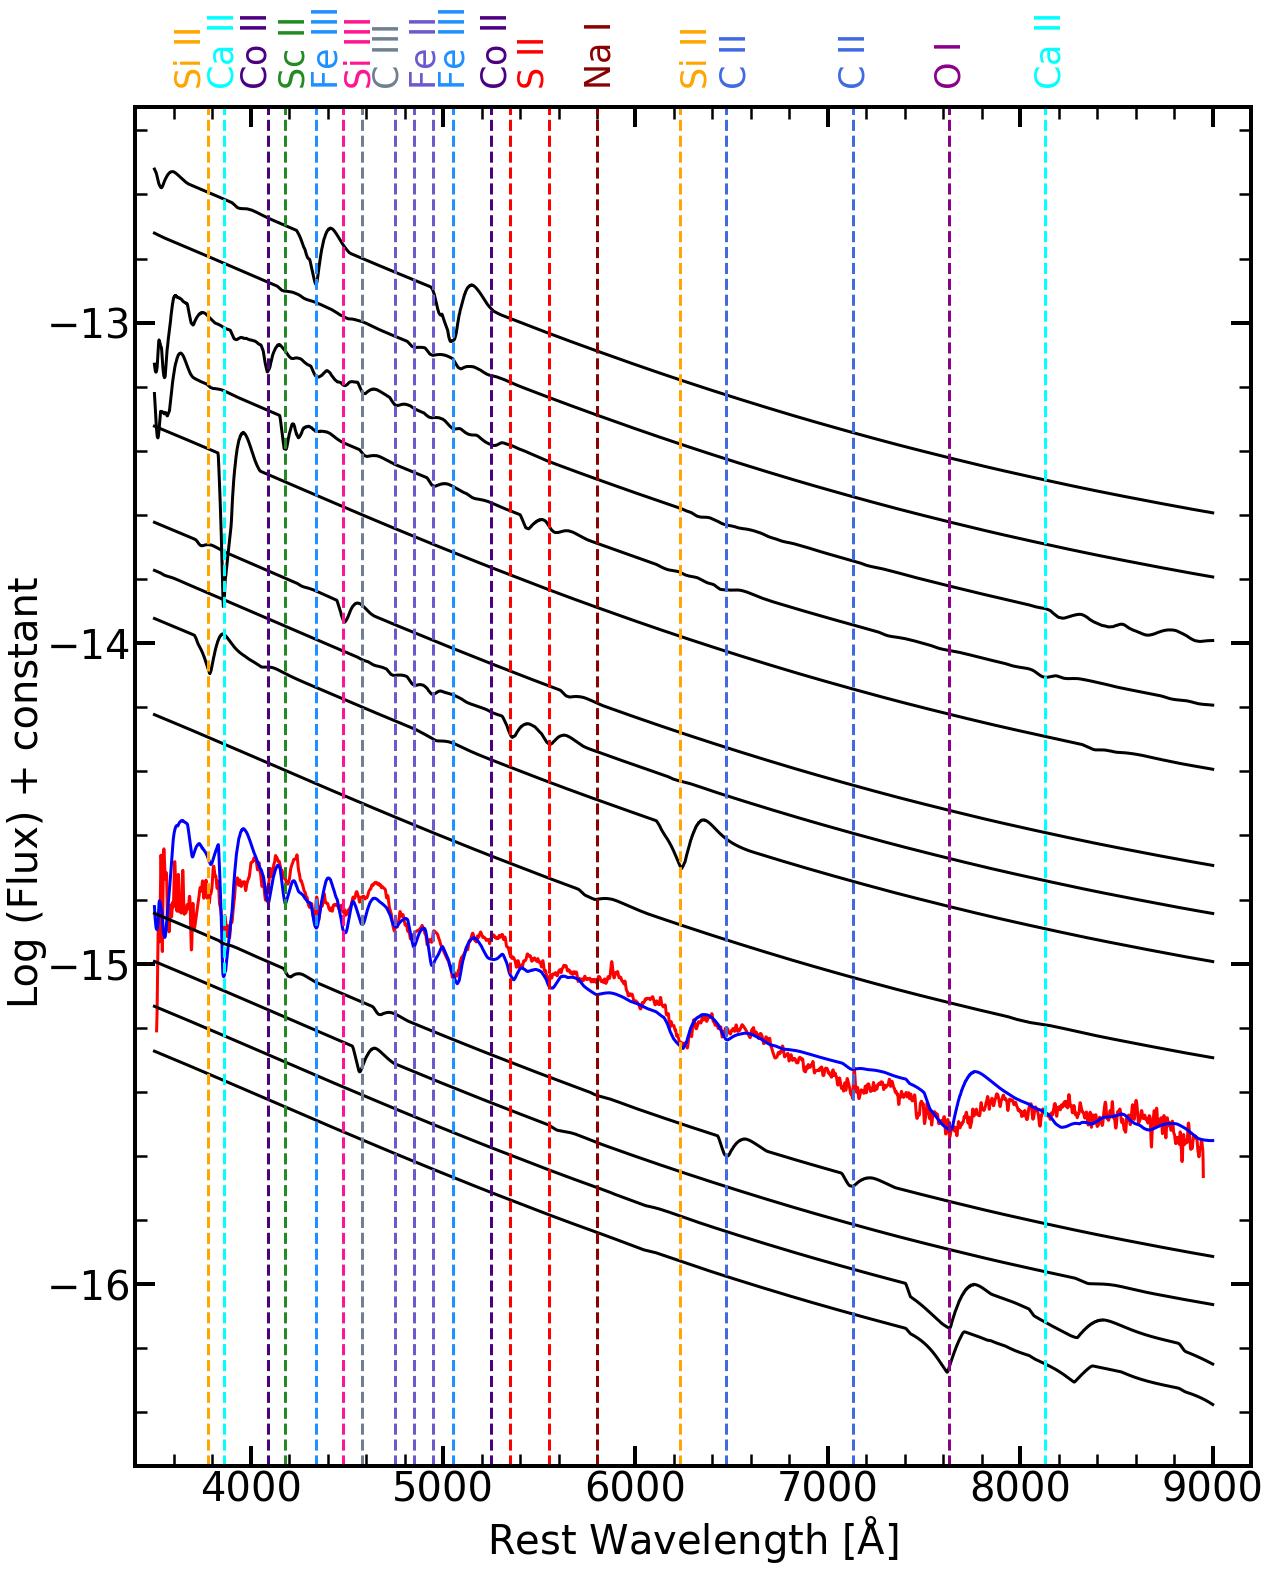

In [200]:
fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(111)
plt.rcParams['axes.linewidth'] = 4
#Useful_python_functions.plot_params(band='A', ax=ax, mil_x=)
    
#col_names = ['Wave', 'Flux']
target_df = pd.read_csv(target_spec, sep='\s+', engine='python')

target_df = target_df[(target_df['Wavelength'] >= int(3510)) & (target_df['Wavelength'] <= int(8952))]
col_names = ['Wave', 'Flux', 'Flux_Err']
si_ii_df = pd.read_csv(si_ii, sep='\s+', names=col_names, engine='python')
s_ii_df = pd.read_csv(s_ii, sep='\s+', names=col_names, engine='python')
si_iii_df = pd.read_csv(si_iii, sep='\s+', names=col_names, engine='python')
c_ii_df = pd.read_csv(c_ii, sep='\s+', names=col_names, engine='python')
c_iii_df = pd.read_csv(c_iii, sep='\s+', names=col_names, engine='python')
o_i_df = pd.read_csv(o_i, sep='\s+', names=col_names, engine='python')
o_id_df = pd.read_csv(o_id, sep='\s+', names=col_names, engine='python')
na_i_df = pd.read_csv(na_i, sep='\s+', names=col_names, engine='python')
ca_ii_df = pd.read_csv(Ca_ii, sep='\s+', names=col_names, engine='python')
sc_ii_df = pd.read_csv(sc_ii, sep='\s+', names=col_names, engine='python')
co_ii_df = pd.read_csv(Co_ii, sep='\s+', names=col_names, engine='python')
co_iii_df = pd.read_csv(Co_iii, sep='\s+', names=col_names, engine='python')
fe_ii_df = pd.read_csv(Fe_ii, sep='\s+', names=col_names, engine='python')
fe_iii_df = pd.read_csv(Fe_iii, sep='\s+', names=col_names, engine='python')
ti_ii_df = pd.read_csv(Ti_ii, sep='\s+', names=col_names, engine='python')
all_df = pd.read_csv(synow_out, sep='\s+', names=col_names, engine='python')
    
ax.plot(target_df['Wavelength'], np.log10(target_df['Flux']), 'r-', lw=3)
ax.plot(all_df['Wave'], np.log10(all_df['Flux']), 'b-', lw=3)

ax.plot(na_i_df['Wave'], np.log10(na_i_df['Flux'])+0.30, 'k-', lw=3.0)
ax.plot(si_ii_df['Wave'], np.log10(si_ii_df['Flux'])+0.60, 'k-', lw=3.0)
ax.plot(s_ii_df['Wave'], np.log10(s_ii_df['Flux'])+0.75, '-', color='black', lw=3.0)
ax.plot(si_iii_df['Wave'], np.log10(si_iii_df['Flux'])+0.90, 'k-', lw=3.0)
ax.plot(ca_ii_df['Wave'], np.log10(ca_ii_df['Flux'])+1.2, 'k-', lw=3.0)
ax.plot(sc_ii_df['Wave'], np.log10(sc_ii_df['Flux'])+1.4, 'k-', lw=3.0)
ax.plot(co_ii_df['Wave'], np.log10(co_ii_df['Flux'])+1.6, 'k-', lw=3.0)
ax.plot(fe_ii_df['Wave'], np.log10(fe_ii_df['Flux'])+1.8, 'k-', lw=3.0)
ax.plot(fe_iii_df['Wave'], np.log10(fe_iii_df['Flux'])+2.0, 'k-', lw=3.0)
#ax.plot(co_iii_df['Wave'], np.log10(co_iii_df['Flux'])+2.2, 'k-')
#ax.plot(ti_ii_df['Wave'], np.log10(ti_ii_df['Flux'])+2.2, 'k-')

ax.plot(c_ii_df['Wave'], np.log10(c_ii_df['Flux'])-0.32, 'k-', lw=3.0)
ax.plot(c_iii_df['Wave'], np.log10(c_iii_df['Flux'])-0.47, 'k-', lw=3.0)
ax.plot(o_i_df['Wave'], np.log10(o_i_df['Flux'])-0.61, 'k-', lw=3.0)
ax.plot(o_id_df['Wave'], np.log10(o_id_df['Flux'])-0.75, 'k-', lw=3.0)


ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))

ax.tick_params(axis = 'both', which = 'major', direction = 'in', 
               length = 20, width = 4.0, labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', 
               length = 12, width = 2.5, labelsize = 12)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 40)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 40)

#ax.set_ylim(-16.2, -13.5)  
ax.set_xlim(3400, 9200)
ax.axvline(6230, ls='--', lw=3.0, color='orange')
ax.axvline(3780, ls='--', lw=3.0, color='orange')
ax.axvline(5350, ls='--', lw=3.0, color='red')
ax.axvline(5550, ls='--', lw=3.0, color='red')
ax.axvline(3860, ls='--', lw=3.0, color='cyan')
ax.axvline(4340, ls='--', lw=3.0, color='dodgerblue')  
ax.axvline(5050, ls='--', lw=3.0, color='dodgerblue')
ax.axvline(4180, ls='--', lw=3.0, color='forestgreen')
ax.axvline(4090, ls='--', lw=3.0, color='indigo')
ax.axvline(6470, ls='--', lw=3.0, color='royalblue')
ax.axvline(7130, ls='--', lw=3.0, color='royalblue')
ax.axvline(4750, ls='--', lw=3.0, color='slateblue')
ax.axvline(4850, ls='--', lw=3.0, color='slateblue')
ax.axvline(4950, ls='--', lw=3.0, color='slateblue')
ax.axvline(4480, ls='--', lw=3.0, color='deeppink')
ax.axvline(4580, ls='--', lw=3.0, color='slategray')
ax.axvline(5250, ls='--', lw=3.0, color='indigo')
ax.axvline(5800, ls='--', lw=3.0, color='darkred')
ax.axvline(7630, ls='--', lw=3.0, color='darkmagenta')
ax.axvline(8130, ls='--', lw=3.0, color='cyan')
ax.text(6230, -12.25, r'$\rm Si\ II$', rotation='vertical', fontsize=35, color='orange')
ax.text(3600, -12.25, r'$\rm Si\ II$', rotation='vertical', fontsize=35, color='orange')
ax.text(5380, -12.25, r'$\rm S\ II$', rotation='vertical', fontsize=35, color='red')
ax.text(3770, -12.25, r'$\rm Ca\ II$', rotation='vertical', fontsize=35, color='cyan')
ax.text(8070, -12.25, r'$\rm Ca\ II$', rotation='vertical', fontsize=35, color='cyan')
ax.text(4820, -12.25, r'$\rm Fe\ II$', rotation='vertical', fontsize=35, color='slateblue')
ax.text(3940, -12.25, r'$\rm Co\ II$', rotation='vertical', fontsize=35, color='indigo')
ax.text(4140, -12.25, r'$\rm Sc\ II$', rotation='vertical', fontsize=35, color='forestgreen')
ax.text(4310, -12.25, r'$\rm Fe\ III$', rotation='vertical', fontsize=35, color='dodgerblue')
ax.text(4970, -12.25, r'$\rm Fe\ III$', rotation='vertical', fontsize=35, color='dodgerblue')
ax.text(4480, -12.25, r'$\rm Si\ III$', rotation='vertical', fontsize=35, color='deeppink')
ax.text(4630, -12.25, r'$\rm C\ III$', rotation='vertical', fontsize=35, color='slategray')
ax.text(5190, -12.25, r'$\rm Co\ II$', rotation='vertical', fontsize=35, color='indigo')
ax.text(5730, -12.25, r'$\rm Na\ I$', rotation='vertical', fontsize=35, color='darkred')
ax.text(6430, -12.25, r'$\rm C\ II$', rotation='vertical', fontsize=35, color='royalblue')
ax.text(7050, -12.25, r'$\rm C\ II$', rotation='vertical', fontsize=35, color='royalblue')
ax.text(7550, -12.25, r'$\rm O\ I$', rotation='vertical', fontsize=35, color='darkmagenta')

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=40)
#ax[0].set_ylabel(r'Scaled Flux [$\rm erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$] + Const.', fontsize=25)
fig.text(.05, .5, r'Log (Flux) + constant', 
         ha='center', va='center', rotation='vertical', fontsize=40);
plt.savefig("/home/anirban/2020sck/Results/New_Results/Results/Plots/Synow.png", dpi=300,
            bbox_inches='tight', facecolor='white')

In [199]:
#smooth_1dspec(common_text='drts*.dat', sp=3, plot=True)